## Extracting Structured Data from ParlaMint-PT (TEI XML)

In this step, we parse the ParlaMint-PT TEI-encoded parliamentary debates and transform them into a structured format suitable for analysis.  
The result is stored in a pandas DataFrame where each row corresponds to a single utterance (<u> element) in the corpus.  

In [23]:
import glob
import os
import lxml.etree as ET
import pandas as pd

# Path to your TEI files
tei_path = "/Users/elisaonder/Desktop/ParlaMint-PT.TEI"

# Load speaker metadata if listPerson.xml exists
speakers_dict = {}
persons_file = os.path.join(tei_path, "ParlaMint-PT-listPerson.xml")
if os.path.exists(persons_file):
    tree = ET.parse(persons_file)
    root = tree.getroot()
    for person in root.findall(".//{*}person"):
        pid = person.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

        # Full name, clean whitespace and join all text parts
        name_el = person.find(".//{*}persName")
        name = " ".join(name_el.itertext()).replace("\n", " ").split() if name_el is not None else pid
        name = " ".join(name)

        # Gender
        sex_el = person.find(".//{*}sex")
        gender = sex_el.attrib.get("value") if sex_el is not None else "Unknown"

        # Party
        affil_el = person.find(".//{*}affiliation")
        party_id = affil_el.attrib.get("ref", "Unknown") if affil_el is not None else "Unknown"
        party_name_el = affil_el.find(".//{*}orgName") if affil_el is not None else None
        party_name = party_name_el.text.strip() if party_name_el is not None else party_id

        speakers_dict[pid] = {
            "name": name,
            "gender": gender,
            "party_id": party_id,
            "party_name": party_name
        }

# Find all session XML files
files = glob.glob(os.path.join(tei_path, "20*/**/*.xml"), recursive=True)
print(f"Found {len(files)} XML files.")

data = []

for f in files:
    if "Schema" in f:
        continue  # Skip schema files

    try:
        tree = ET.parse(f)
        root = tree.getroot()

        # Session metadata
        session_id = root.attrib.get("{http://www.w3.org/XML/1998/namespace}id", os.path.basename(f))
        session_title_el = root.find(".//{*}title")
        session_title = session_title_el.text.strip() if session_title_el is not None and session_title_el.text else "Unknown"

        # Extract year from session_id (ParlaMint-PT_YYYY-MM-DD)
        try:
            year = session_id.split("_")[1].split("-")[0]
        except:
            year = "Unknown"

        # Date: fallback to <date> if available
        date_el = root.find(".//{*}date")
        if date_el is not None and date_el.attrib.get("when"):
            session_date = date_el.attrib.get("when")
        else:
            # Use session_id date if <date> is missing
            session_date = "_".join(session_id.split("_")[1:])

        # Utterances
        for u in root.findall(".//{*}u"):
            speech_id = u.attrib.get("{http://www.w3.org/XML/1998/namespace}id")

            speaker_id = u.attrib.get("who")
            speaker_id = speaker_id.lstrip("#") if speaker_id else "Unknown"

            speech_type = u.attrib.get("ana", "Unknown")
            lang = u.attrib.get("{http://www.w3.org/XML/1998/namespace}lang", "pt")

            # Get speaker info
            speaker_info = speakers_dict.get(
                speaker_id,
                {"name": speaker_id, "gender": "Unknown", "party_id": "Unknown", "party_name": "Unknown"}
            )

            # Combine <seg> text
            text = " ".join(seg.text.strip() for seg in u.findall(".//{*}seg") if seg.text)
            word_count = len(text.split())

            data.append([
                speech_id, session_id, session_title, session_date, year,
                speaker_id, speaker_info["name"], speaker_info["party_id"], speaker_info["party_name"],
                speaker_info["gender"], speech_type, lang,
                word_count, text
            ])

    except Exception as e:
        print(f"⚠️ Error parsing {f}: {e}")

# Create DataFrame
df = pd.DataFrame(data, columns=[
    "speech_id", "session_id", "session_title", "date", "year",
    "speaker_id", "speaker_name", "party_id", "party_name",
    "gender", "speech_type", "language",
    "word_count", "text"
])

# Preview
print(df.head(10))

# Optionally save to CSV
# df.to_csv("ParlaMint_PT_corpus_all_years.csv", index=False)


Found 901 XML files.
                     speech_id               session_id  \
0   ParlaMint-PT_2022-06-02.u1  ParlaMint-PT_2022-06-02   
1   ParlaMint-PT_2022-06-02.u2  ParlaMint-PT_2022-06-02   
2   ParlaMint-PT_2022-06-02.u3  ParlaMint-PT_2022-06-02   
3   ParlaMint-PT_2022-06-02.u4  ParlaMint-PT_2022-06-02   
4   ParlaMint-PT_2022-06-02.u5  ParlaMint-PT_2022-06-02   
5   ParlaMint-PT_2022-06-02.u6  ParlaMint-PT_2022-06-02   
6   ParlaMint-PT_2022-06-02.u7  ParlaMint-PT_2022-06-02   
7   ParlaMint-PT_2022-06-02.u8  ParlaMint-PT_2022-06-02   
8   ParlaMint-PT_2022-06-02.u9  ParlaMint-PT_2022-06-02   
9  ParlaMint-PT_2022-06-02.u10  ParlaMint-PT_2022-06-02   

                                       session_title        date  year  \
0  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
1  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
2  Corpus parlamentar português ParlaMint-PT, Sér...  2025-06-20  2022   
3  Corpus parlamentar português P

In [24]:
# Example: print the first row completely
print(df.iloc[0].to_string())

speech_id                               ParlaMint-PT_2022-06-02.u1
session_id                                 ParlaMint-PT_2022-06-02
session_title    Corpus parlamentar português ParlaMint-PT, Sér...
date                                                    2025-06-20
year                                                          2022
speaker_id                               AugustoErnestoSantosSilva
speaker_name                          Augusto Ernesto Santos Silva
party_id                                                       #PS
party_name                                                     #PS
gender                                                           M
speech_type                                     #chair topic:other
language                                                        pt
word_count                                                      75
text             Sr.as Deputadas e Srs. Deputados, Srs. Jornali...


## Overview of the Dataset

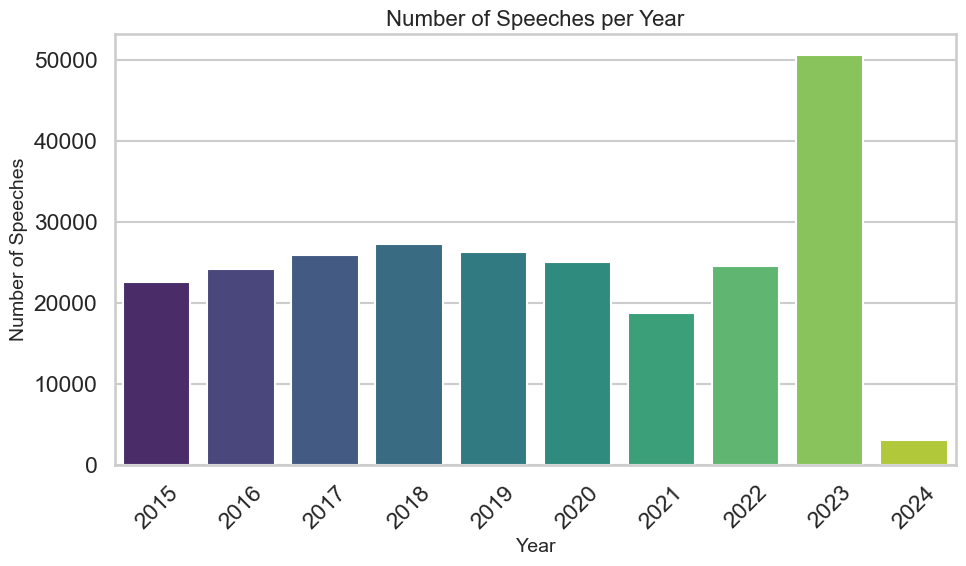

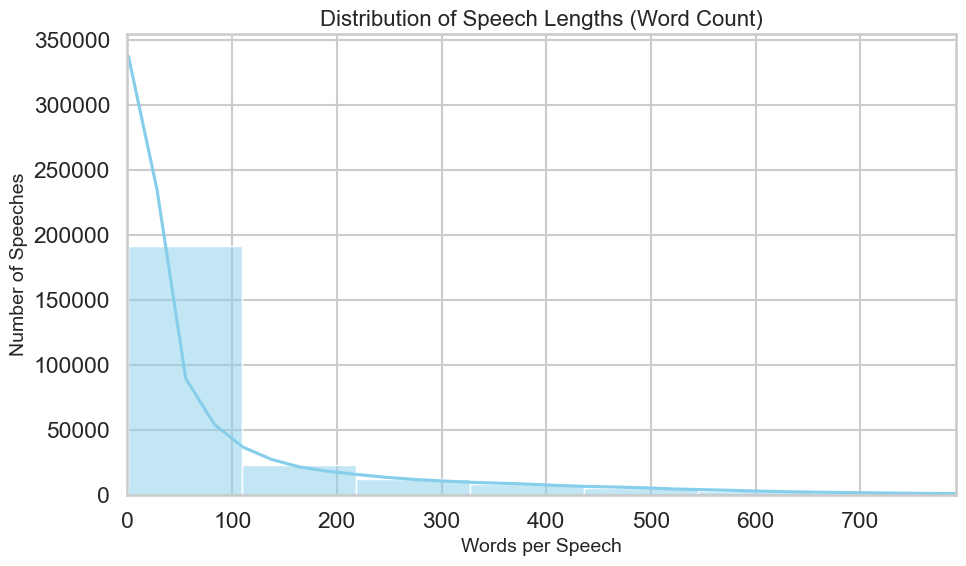

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", context="talk", palette="muted")

# ----- Number of speeches per year -----
plt.figure(figsize=(10,6))
speech_counts = df.groupby('year')['speech_id'].count().sort_index()
sns.barplot(x=speech_counts.index, y=speech_counts.values, palette="viridis")
plt.title("Number of Speeches per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ----- Distribution of speech lengths -----
plt.figure(figsize=(10,6))
sns.histplot(df['word_count'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Speech Lengths (Word Count)", fontsize=16)
plt.xlabel("Words per Speech", fontsize=14)
plt.ylabel("Number of Speeches", fontsize=14)
plt.xlim(0, df['word_count'].quantile(0.99))  # limit x-axis to 99th percentile to avoid long tails
plt.tight_layout()
plt.show()


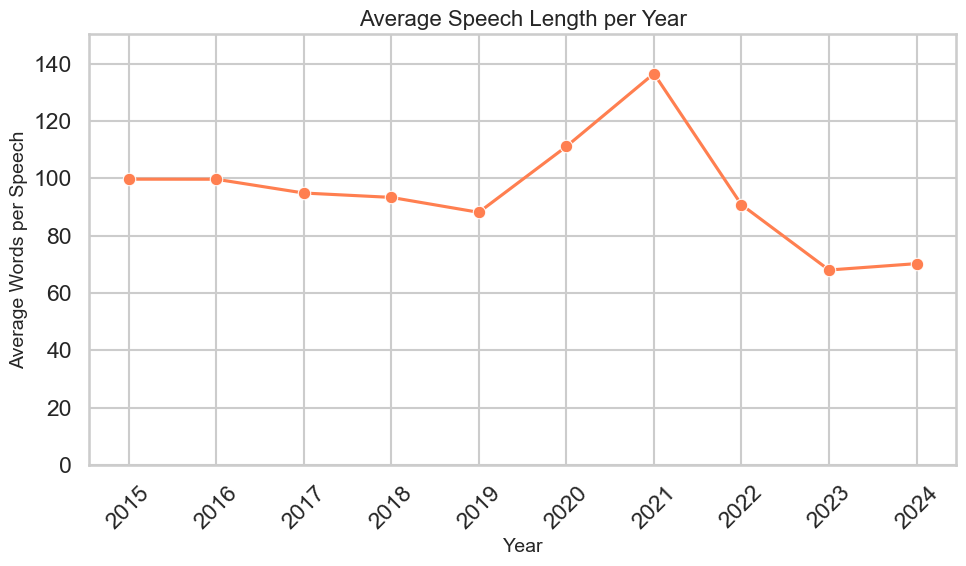

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", context="talk", palette="muted")

# Compute average speech length per year
avg_length = df.groupby('year')['word_count'].mean().sort_index()

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(x=avg_length.index, y=avg_length.values, marker="o", color="coral")
plt.title("Average Speech Length per Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Words per Speech", fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, avg_length.max()*1.1)  # Add a little space above max
plt.tight_layout()
plt.show()
